In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
#Setting path to the database file
database_path = "Resources/hawaii.sqlite"

# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables

Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
aug_temps = calc_temps('2017-08-01', '2017-08-07')
for min, avg, max in aug_temps:
    min = min
    avg = avg
    max = max

83.0

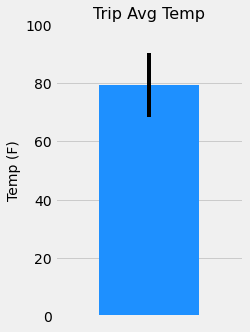

In [130]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#Set the size of the figure
plt.figure(figsize=(3,5))

#Set the chart type as bar, x-axis is zero, y-axis is mean temp, set color, error bar is max-min temp difference
plt.bar([0], avg, color = 'dodgerblue', yerr = max - min)

#Set title
plt.title("Trip Avg Temp", fontsize = (16))

#Set y label
plt.ylabel('Temp (F)', fontsize = (14))

#Set x and y limits
plt.xlim(-0.75,0.75)
plt.ylim(0,100)

#Keep labels off of x-axis
plt.tick_params(axis='x', labelbottom=False)

#Adjust grid to only display along the y lines
plt.grid(axis='x')

#Display the chart
plt.show()



### Daily Rainfall Average

In [132]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = (Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp))

#Query for the data and also set prcp readings by descending order
trip_rain = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= '2017-08-01').\
    filter(Measurement.date <= '2017-08-07').group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

#Make a dataframe and set column names
trip_rain_df = pd.DataFrame(trip_rain, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Total Precipitation (8/1 - 8/7)'])

#Display df
trip_rain_df

,Station,Name,Latitude,Longitude,Elevation,Total Precipitation (8/1 - 8/7)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [74]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [133]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2021-08-01'
end_date = '2021-08-07'

# Use the start and end date to create a range of dates

#Put into strptime format for later year removal
start_str = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_str = dt.datetime.strptime(end_date, '%Y-%m-%d')

#Empty list to hold dates
datelist = []

#Empty list to hold the normals values
normals = []

#Loop through date range and append empty date list with dates for the trip range (including year)
#Also set a variable to allow for stripping off the year to use in daily_normals function
#call daily normal function on each month/day in the date rang and append the normals list with the calculated 'normals'

while end_str >= start_str:
    
    date_item = dt.datetime.strftime(start_str,'%m-%d')
    datelist.append(dt.datetime.strftime(start_str,'%Y-%m-%d'))
    
    #Put into an array for putting into df later
    normals.append(list(np.ravel(daily_normals(date_item))))
    start_str = start_str + dt.timedelta(days = 1)
    

In [134]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Minimum Temperature','Average Temperature', 'Maximum Temperature'])
normals_df['Date'] = datelist

# Set the date column as the DataFrame index
normals_df = normals_df.set_index('Date')

#Display the df
normals_df

,Minimum Temperature,Average Temperature,Maximum Temperature
Date,,,
2021-08-01,67.0,75.540000,83.0
2021-08-02,68.0,75.603774,84.0
2021-08-03,70.0,76.611111,85.0
2021-08-04,69.0,76.711538,84.0
2021-08-05,69.0,76.148148,82.0
2021-08-06,67.0,76.250000,83.0
2021-08-07,71.0,77.156863,83.0


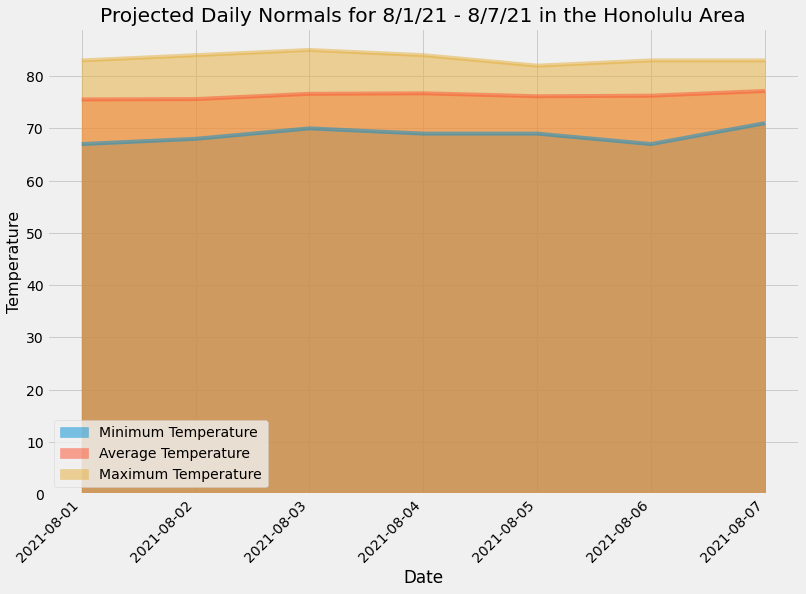

In [139]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked = False, figsize=(12,8))

#Set placement of x axis date labels - align wit the vertical lines of the grid
plt.xticks(rotation = 45, ha = 'right')

#Set title and y axis label
plt.title("Projected Daily Normals for 8/1/21 - 8/7/21 in the Honolulu Area")
plt.ylabel("Temperature", fontsize = (16))

#Display plot
plt.show()

## Close Session

In [140]:
session.close()